In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from matplotlib import pylab as plt
import numpy as np
# import matplotlib #don't delete!

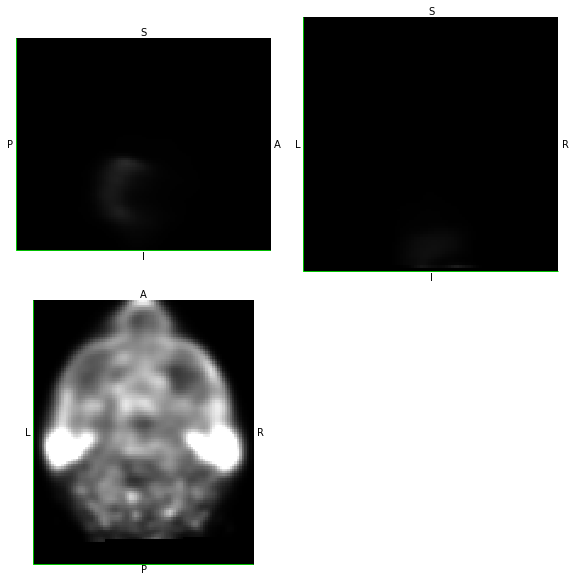

(91, 109, 91)

In [2]:
from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
example_filename = "./datasets/A4/A4_aligned/B10018169/Florbetapir/cmeanA4_B10018169_MR_Florbetapir_Br_20200720182306561_S893044_I1321166.nii.gz"
 
img = nib.load(example_filename)
OrthoSlicer3D(img.dataobj).show()
fdata=img.get_fdata()
fdata.shape

In [1]:
from dataloader.A4 import preprocess_save_img,load_data
from sklearn.model_selection import train_test_split,KFold

x=load_data("A4_PETVADATA_PRV2.csv",max_size=50)
# pre_fy=lambda y:1 if y=="positive" else 0
# dataset=(x,y)
x_train,x_test=train_test_split(
    x,test_size=0.1,random_state=1919810
)
x_train,x_val=train_test_split(
    x_train,test_size=0.05,random_state=114514
)

train_data_dir="datasets/A4/train"
val_data_dir="datasets/A4/val"
test_data_dir="datasets/A4/test"

train_data_file=preprocess_save_img(x_train,train_data_dir,4)
val_data_file=preprocess_save_img(x_val,val_data_dir)
test_data_file=preprocess_save_img(x_test,test_data_dir)

# train_d,val_d,test_d=(
#     A4Dataset_train(x_train,y_train,ag_rate=4,batch_size=64,pre_fy=pre_fy),
#     A4Dataset_test(x_val,y_val,batch_size=64,pre_fy=pre_fy),
#     A4Dataset_test(x_test,y_test,batch_size=64,pre_fy=pre_fy)
# )

print("Train imgs:",len(x_train))
print("Val imgs:",len(x_val))
print("Test imgs:",len(x_test))

# kf = KFold(n_splits=10)

  2%|▏         | 103/4492 [00:00<00:10, 429.02it/s]


Total data number:100
unusable BID:['B11187381', 'B11238033', 'B11255389']


100%|██████████| 85/85 [00:08<00:00,  9.47it/s]


(425, 42, 50, 42)


100%|██████████| 5/5 [00:00<00:00, 23.62it/s]


(5, 42, 50, 42)


100%|██████████| 10/10 [00:00<00:00, 22.81it/s]

(10, 42, 50, 42)
Train imgs: 85
Val imgs: 5
Test imgs: 10


In [2]:
### make target data
from dataloader.A4 import preprocess_save_target
d={
    "csv_name":"A4_PETVADATA_PRV2.csv",
    "target_column":"SCORE",
    "prefunc":lambda x:1 if x[0]=="p"else 0
}
train_target_file=preprocess_save_target(train_data_dir,**d)
val_target_file=preprocess_save_target(val_data_dir,**d)
test_target_file=preprocess_save_target(test_data_dir,**d)


(425,)
(5,)
(10,)


In [4]:
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import time
from units.model import CNN3D

cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=CNN3D()
history=model.fit(
    x=np.load(train_data_file,"r"),
    y=np.load(train_target_file,"r"),
    batch_size=64,epochs=30,callbacks=cb,
    validation_data=(np.load(val_data_file,"r"),np.load(val_target_file,"r"))
)

model.save("./models/m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())))
model.save("./models/latest.h5")

# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

Epoch 1/2
7/7 [==============================] - 26s 3s/step - loss: 0.7749 - sparse_categorical_accuracy: 0.4212 - val_loss: 0.6960 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/2
7/7 [==============================] - 24s 3s/step - loss: 0.7816 - sparse_categorical_accuracy: 0.4047 - val_loss: 0.6964 - val_sparse_categorical_accuracy: 0.2000


In [5]:
### advanced learn
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=load_model("./models/latest.h5")
history=model.fit(
    x=np.load(train_data_file,"r"),
    y=np.load(train_target_file,"r"),
    batch_size=64,epochs=30,callbacks=cb,
    validation_data=(np.load(val_data_file,"r"),np.load(val_target_file,"r"))
)

model.save("./models/m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())))
model.save("./models/latest.h5")

Epoch 1/2
7/7 [==============================] - 27s 4s/step - loss: 0.7473 - sparse_categorical_accuracy: 0.4518 - val_loss: 0.6963 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/2
7/7 [==============================] - 26s 4s/step - loss: 0.7499 - sparse_categorical_accuracy: 0.4235 - val_loss: 0.6948 - val_sparse_categorical_accuracy: 0.4000


In [7]:
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
import os

model=load_model("./models/latest.h5")
test_data_dir="datasets/A4/test"
test_data_file=os.path.join(test_data_dir,"dataset.npy")
test_target_file=os.path.join(test_data_dir,"target.npy")

x_test=np.load(test_data_file,"r")
y_testtruth=np.load(test_target_file,"r")

y_predit=model.predict(x_test)
tot=metrics.sparse_categorical_accuracy(y_testtruth,y_predit)
acc=sum(tot)/len(tot)
print("Test accuracy={}".format(acc.numpy()))


Test accuracy=0.4000000059604645


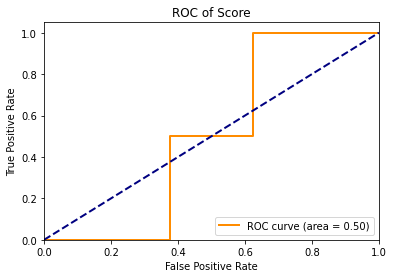

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp


# ylabel=label_binarize(y_testp,classes=[0,1])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
fpr, tpr, _ = roc_curve(y_testtruth, y_predit[:, 1])
roc_auc = auc(fpr, tpr)
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.title('ROC of Score')
plt.legend(loc="lower right")
plt.show()
